In [95]:
### dimension reduce & cluster with UMAP

import umap
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from io import BytesIO
from PIL import Image
import base64

from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.transform import factor_mark

In [96]:
## import features and charter listf

array_path = r"/home/tschernn/becore-clustering/img_array.pkl"

with open(array_path, 'rb') as file:
    img_array = pickle.load(file)

feature_path = r"/home/tschernn/becore-clustering/features_hog.pkl"

with open(feature_path, 'rb') as file:
    data = pickle.load(file)

charter_path = r"/home/tschernn/becore-clustering/charter_list.pkl"

with open(charter_path, 'rb') as file:
    charters = pickle.load(file)

data.shape

(198, 198)

In [97]:
img_vectors = [img.flatten() for img in img_array]
img_vectors = np.array(img_vectors)
img_vectors.shape

(198, 3000000)

In [98]:
## fit and transform

reducer = umap.UMAP()
embedding = reducer.fit_transform(data)

# UMAP by default reduces to 2D
embedding.shape

(198, 2)

In [99]:
reducer = umap.UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)
reducer.fit(data.data)

embedding = reducer.transform(data.data)

/home/tschernn/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


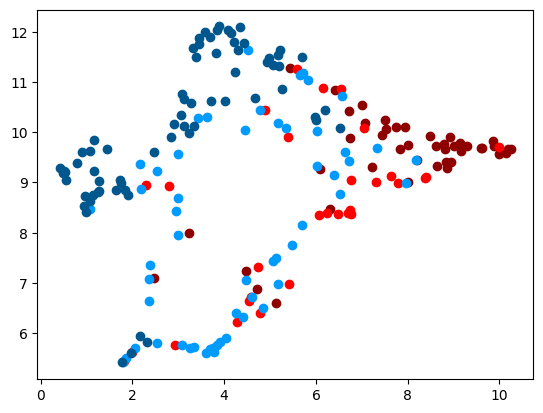

In [100]:
## plot data

label_color_map = {
    'writable_area_notar_oe': '#8e0000', # dark red
    'writable_area_notar_fr': '#ff0000', # light red
    'writable_area_papst_oe': '#00578e', # dark blue
    'writable_area_papst_fr': '#009bff' # light blue 
}

for point, charter in zip(embedding, charters):
    x,y = point
    label = charter[1]
    color = label_color_map[label]
    plt.scatter(x, y, c=color)

In [101]:
### export data as pickle file
feature_path = feature_path.split('.')[0]
feature_path = feature_path + '_dimred.pkl'

with open(feature_path,'wb') as file:
    pickle.dump(embedding, file)
    print(f'Saved features as {file.name}.')

Saved features as /home/tschernn/becore-clustering/features_hog_dimred.pkl.


In [102]:
### remove unneeded img_array dimensions

img_array = img_array[:, :, :, 0]
img_array.shape

(198, 1000, 1000)

In [103]:
### bokeh implementation adapted from https://umap-learn.readthedocs.io/en/latest/basic_usage.html

def embeddable_image(data):
    img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((256, 256), Image.Resampling.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()


## draw plot

output_notebook()

charters_df = pd.DataFrame(embedding, columns=('x', 'y'))
charters_df['class'] = [x[1] for x in charters]
#charters_df['class'] = [x[1].split('_')[-2] for x in charters]
#charters_df['origin'] = [x[1].split('_')[-1] for x in charters]
charters_df['image'] = list(map(embeddable_image, img_array))
charters_df['name'] = [x[0] for x in charters]

datasource = ColumnDataSource(charters_df)
color_mapping = CategoricalColorMapper(factors=['writable_area_notar_oe', 'writable_area_notar_fr', 'writable_area_papst_oe', 'writable_area_papst_fr'],
                                       palette=['#8e0000', '#ff0000', '#00578e', '#009bff'])
#origins = charters_df['origin'].unique()
#markers = ['circle', 'triangle']

plot_figure = figure(
    title='UMAP projection of the charters',
    width=600,
    height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Charter:</span>
        <span style='font-size: 18px'>@name</span>
    </div>
</div>
"""))

for i, origin in enumerate(origins):
    plot_figure.scatter(
        'x',
        'y',
        source=datasource,
        color=dict(field='class', transform=color_mapping),
        #marker=markers[i % len(markers)],
        line_alpha=0.6,
        fill_alpha=0.6,
        size=7
    )
save(plot_figure, filename='umap_plot.html')
#show(plot_figure)

Loading BokehJS ...

/home/tschernn/becore-clustering/ipykernel_1600888/3077260485.py:59: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(plot_figure, filename='umap_plot.html')
/home/tschernn/becore-clustering/ipykernel_1600888/3077260485.py:59: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  save(plot_figure, filename='umap_plot.html')


'/home/tschernn/becore-clustering/umap_plot.html'